In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
import torchmetrics
from tqdm import tqdm

# Downloading data

In [2]:
# Training data
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

# Testing data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

##### Let's look at our data shape.

In [3]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

##### We can know it is a gray scale image with 28 by 28 pixels and the number is classiied as 5.
##### For those of you unfamiliar with this dataset, there are basically 10 numbers to predict, ranging from 0 to 9.
##### So it is a multi-class classification problem.

In [4]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

##### We can also visualize the first number, 5.

Image shape: torch.Size([1, 28, 28])


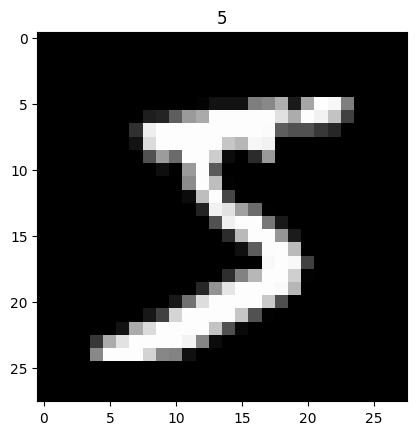

In [5]:
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap='gray') # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

# Preparing Data

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Setting up device (MPS)

In [7]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

# Building a base model

##### Let's create the most basic model we can possibly create.

In [8]:
class basic_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer(x)

In [9]:
torch.manual_seed(42)
basic_model = basic_model(784, 50, len(class_names))
basic_model.to(device)

basic_model(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(basic_model.parameters(), lr = 0.1)
acc_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

##### Let's create the training and testing loop

In [11]:
epochs = 20
train_loss_arr = []
test_loss_arr = []
for epoch in tqdm(range(epochs)):

    # Training loop
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        basic_model.train()

        # Forward
        y_pred = basic_model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # Zero grad
        optimizer.zero_grad()

        # Loss bakward
        loss.backward()

        # Step optimizer
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_loss_arr.append(train_loss)

    # Testing loop
    test_loss, test_acc = 0, 0
    basic_model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Forward
            y_pred = basic_model(X)

            # Calculate loss
            test_loss += loss_fn(y_pred, y)
            # Calculate accuracy 
            test_acc += acc_fn(y, y_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_loss_arr.append(test_loss)
        test_acc /= len(test_dataloader)

    print(f"Training Loss: {train_loss:.5f} | Testing Loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}%")



  5%|▌         | 1/20 [00:05<01:43,  5.47s/it]

Training Loss: 0.39420 | Testing Loss: 0.30071, Test Acc: 0.91484%


 10%|█         | 2/20 [00:10<01:35,  5.31s/it]

Training Loss: 0.30821 | Testing Loss: 0.29111, Test Acc: 0.91823%


 15%|█▌        | 3/20 [00:15<01:29,  5.24s/it]

Training Loss: 0.29527 | Testing Loss: 0.29417, Test Acc: 0.91444%


 20%|██        | 4/20 [00:21<01:23,  5.22s/it]

Training Loss: 0.28933 | Testing Loss: 0.29032, Test Acc: 0.91983%


 25%|██▌       | 5/20 [00:26<01:18,  5.21s/it]

Training Loss: 0.28458 | Testing Loss: 0.31327, Test Acc: 0.91294%


 30%|███       | 6/20 [00:31<01:12,  5.20s/it]

Training Loss: 0.28123 | Testing Loss: 0.29349, Test Acc: 0.91893%


 35%|███▌      | 7/20 [00:36<01:07,  5.21s/it]

Training Loss: 0.27849 | Testing Loss: 0.27241, Test Acc: 0.92442%


 40%|████      | 8/20 [00:41<01:02,  5.22s/it]

Training Loss: 0.27694 | Testing Loss: 0.27583, Test Acc: 0.92232%


 45%|████▌     | 9/20 [00:47<00:57,  5.21s/it]

Training Loss: 0.27446 | Testing Loss: 0.28318, Test Acc: 0.91963%


 50%|█████     | 10/20 [00:52<00:52,  5.21s/it]

Training Loss: 0.27304 | Testing Loss: 0.27414, Test Acc: 0.92382%


 55%|█████▌    | 11/20 [00:57<00:47,  5.25s/it]

Training Loss: 0.27153 | Testing Loss: 0.28500, Test Acc: 0.91993%


 60%|██████    | 12/20 [01:02<00:42,  5.25s/it]

Training Loss: 0.27027 | Testing Loss: 0.28659, Test Acc: 0.91973%


 65%|██████▌   | 13/20 [01:08<00:36,  5.25s/it]

Training Loss: 0.26862 | Testing Loss: 0.29993, Test Acc: 0.91793%


 70%|███████   | 14/20 [01:13<00:31,  5.26s/it]

Training Loss: 0.26775 | Testing Loss: 0.27851, Test Acc: 0.92083%


 75%|███████▌  | 15/20 [01:18<00:26,  5.25s/it]

Training Loss: 0.26766 | Testing Loss: 0.27382, Test Acc: 0.92392%


 80%|████████  | 16/20 [01:24<00:21,  5.29s/it]

Training Loss: 0.26622 | Testing Loss: 0.28479, Test Acc: 0.92053%


 85%|████████▌ | 17/20 [01:29<00:15,  5.28s/it]

Training Loss: 0.26504 | Testing Loss: 0.28896, Test Acc: 0.92173%


 90%|█████████ | 18/20 [01:34<00:10,  5.30s/it]

Training Loss: 0.26469 | Testing Loss: 0.27925, Test Acc: 0.92392%


 95%|█████████▌| 19/20 [01:39<00:05,  5.28s/it]

Training Loss: 0.26342 | Testing Loss: 0.30352, Test Acc: 0.91623%


100%|██████████| 20/20 [01:45<00:00,  5.26s/it]

Training Loss: 0.26341 | Testing Loss: 0.27738, Test Acc: 0.92093%


##### We can plot the train and test loss values.

In [12]:
# Detaching MPS values to CPU and converting them to plottable type

train_loss_arr_np = []
for val in train_loss_arr:
    train_loss_arr_np.append(val.cpu().detach().numpy())

test_loss_arr_np = []
for val in test_loss_arr:
    test_loss_arr_np.append(val.cpu().detach().numpy())

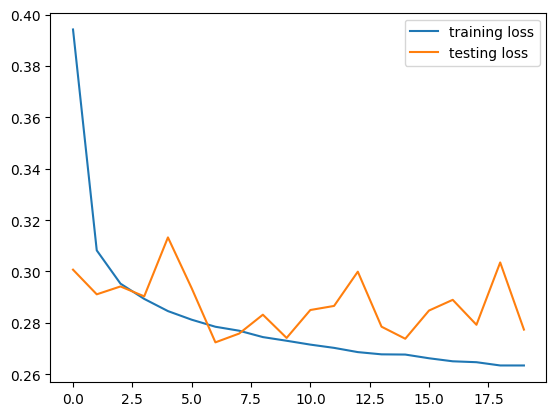

In [13]:
x = [i for i in range(20)]
plt.plot(x, train_loss_arr_np, label = "training loss", linestyle="-")
plt.plot(x, test_loss_arr_np, label = "testing loss", linestyle="-")
plt.legend()

##### The reason why these kind of plots are useful is that it helps the user to spot overfitting tendencies. 
##### As we can see from this plot, there is clear overfitting. 
##### As the model takes more epochs to train, the training loss obviously keeps decreasing but the testing loss is not reflecting the same improvement. 
##### The testing loss does not change much from the original testing loss. 
##### This goes on to show that we are currently overfitting and without model, there is not much more room for improvement. 
##### We would need to think of a different model architecture to hope for an improvement.

# Building a CNN model

In [14]:
class CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # hidden_units x 14 x 14
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 5, 1, 1), # hidden_units x 12 x 12
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 5, 1, 1), # hidden_units x 10 x 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # hidden_units x 5 x 5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*5*5, output_shape)
        )

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.classifier(x)
        return x 

CNN = CNN(1, 50, len(class_names)).to(device)
CNN


CNN(
  (layer_1): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1250, out_features=10, bias=True)
  )
)

##### Setting up loss and optimizer.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr = 0.1)
acc_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

##### Let's go through the usual training and testing process now.

In [16]:
epochs = 10
train_loss_arr = []
test_loss_arr = []
for epoch in tqdm(range(epochs)):
    # Training loop
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        CNN.train()

        # Forward
        y_pred = CNN(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # Zero grad
        optimizer.zero_grad()

        # Loss bakward
        loss.backward()

        # Step optimizer
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_loss_arr.append(train_loss)

    # Testing loop
    test_loss, test_acc = 0, 0
    CNN.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Forward
            y_pred = CNN(X)

            # Calculate loss
            test_loss += loss_fn(y_pred, y)
            # Calculate accuracy 
            test_acc += acc_fn(y, y_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_loss_arr.append(test_loss)
        test_acc /= len(test_dataloader)

    print(f"Training Loss: {train_loss:.5f} | Testing Loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}%")

 10%|█         | 1/10 [00:29<04:28, 29.80s/it]

Training Loss: 0.16437 | Testing Loss: 0.04167, Test Acc: 0.98612%


 20%|██        | 2/10 [00:59<03:58, 29.77s/it]

Training Loss: 0.04577 | Testing Loss: 0.03050, Test Acc: 0.98932%


 30%|███       | 3/10 [01:29<03:27, 29.69s/it]

Training Loss: 0.03139 | Testing Loss: 0.02764, Test Acc: 0.99071%


 40%|████      | 4/10 [01:58<02:57, 29.66s/it]

Training Loss: 0.02314 | Testing Loss: 0.02479, Test Acc: 0.99201%


 50%|█████     | 5/10 [02:25<02:23, 28.74s/it]

Training Loss: 0.01822 | Testing Loss: 0.02714, Test Acc: 0.99052%


 60%|██████    | 6/10 [02:54<01:55, 28.76s/it]

Training Loss: 0.01379 | Testing Loss: 0.02670, Test Acc: 0.99171%


 70%|███████   | 7/10 [03:23<01:25, 28.66s/it]

Training Loss: 0.01181 | Testing Loss: 0.03416, Test Acc: 0.98912%


 80%|████████  | 8/10 [03:52<00:57, 28.92s/it]

Training Loss: 0.01077 | Testing Loss: 0.02662, Test Acc: 0.99111%


 90%|█████████ | 9/10 [04:22<00:29, 29.14s/it]

Training Loss: 0.00764 | Testing Loss: 0.03349, Test Acc: 0.99101%


100%|██████████| 10/10 [04:51<00:00, 29.13s/it]

Training Loss: 0.00741 | Testing Loss: 0.02684, Test Acc: 0.99201%


In [22]:
# Detaching MPS values to CPU and converting them to plottable type

train_loss_arr_np = []
for val in train_loss_arr:
    train_loss_arr_np.append(val.cpu().detach().numpy())

test_loss_arr_np = []
for val in test_loss_arr:
    test_loss_arr_np.append(val.cpu().detach().numpy())

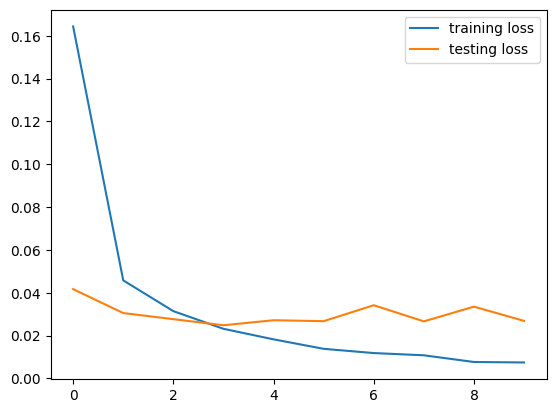

In [23]:
x = [i for i in range(10)]
plt.plot(x, train_loss_arr_np, label = "training loss", linestyle="-")
plt.plot(x, test_loss_arr_np, label = "testing loss", linestyle="-")
plt.legend()

##### Just by looking at the accuracy, we already can see how well our model is performing relative to the base line model.
##### By doing at the plot, we can see what the start of an overfitting line might look like. 
##### However, 10 epochs seems enough for our model to train.
##### With a accuracy of 99.2%, we seem to have reached a very effective model.

# Making Predictions

##### Let's look at some of our model's predictions.

In [25]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [26]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [28]:
pred_probs= make_predictions(model=CNN, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

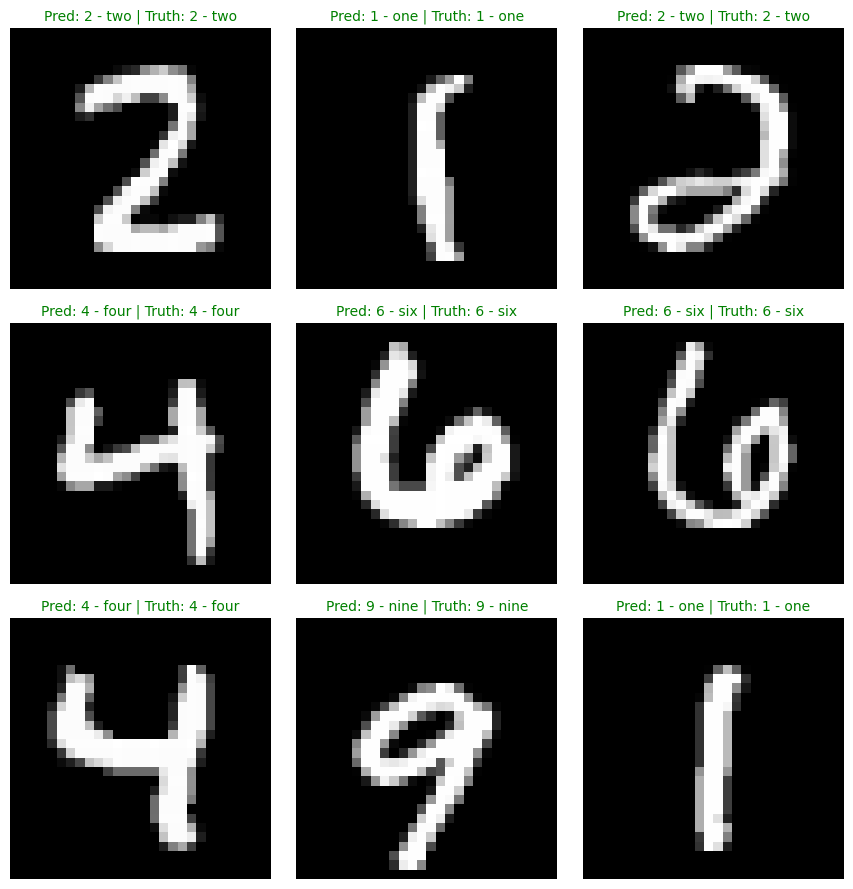

In [30]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

  plt.tight_layout()

##### Seems like we created a very effective model based on the idea of Convolutional Neural Network.
##### Give it a try for yourself!